# Researching Twitter

A. The hashtag '#aww' was searched for in the English language downloading the first 500 tweets for ten months of year 2022, collecting a total of 5000 tweets. '#aww' posts tend to be associated with media depicting pets and/or babies in generally considered 'adorable' activities.

B. A set of keywords often associated with #aww posts was set – cat, dog, fish, turtle, baby, bird, rabbit, horse, ferret, and pig.

C. Initially a simple keyword search was conducted on the lemmatized text of each tweet and counts of each keyword were tallied. And cats win over dogs by a whisker 😺😺😺😺, with 2067 mentions vs. 1874 respectively. The next closest was 'baby' and the closest animal was 'rabbit' with 156. Horses, fish, and ferrets were not particularly popular!

D. A model was built using 'baby' as a dependant (see what I did there) variable against the remaining keywords. Not a particularly useful model admittedly with 'kitten' and 'puppy' being preferrable to 'baby cat' and 'baby dog.' So not particularly predictive. But an effort was made.

E. Also a relationship graph was constructed of the keywords, which again probably does not reveal too much. The adjacency of 'cat' and 'baby'; 'baby' and 'fish'; and 'cat' and 'fish' would seem to have some meaning as posts' media can include combinations such as a cat staring into a fish tank as well as a cat interacting with a baby. Unsurprisingly we are not seeing much proximity between babies and horses, ferrets, pigs, or turtles.

In [1]:
# Code block 1: installations
!pip install git+https://github.com/tweepy/tweepy.git
!pip install pyreadstat
!pip install researchpy
!pip install openpyxl --upgrade
!pip install contractions

  Cloning https://github.com/tweepy/tweepy.git to /private/var/folders/n3/7lr2xtgs72g16rs2rfk0gvgw0000gn/T/pip-req-build-elsfgzvr
  Running command git clone -q https://github.com/tweepy/tweepy.git /private/var/folders/n3/7lr2xtgs72g16rs2rfk0gvgw0000gn/T/pip-req-build-elsfgzvr
  Resolved https://github.com/tweepy/tweepy.git to commit 4b0fa90e91eb2b67dfd33f0d27b148e95ea05f65


In [2]:
# Code block 2a: Import libraries
import tweepy as twp
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sb
import json
import math
import collections as cl
import matplotlib.pyplot as plt
import researchpy as rp
import re
import contractions
import string
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances


/Users/michaelsmith/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/michaelsmith/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [3]:
# Code block 2b: Import NLTK
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import wordnet as wn

wnl = nltk.WordNetLemmatizer()
wnp = nltk.PorterStemmer()
en_stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/michaelsmith/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/michaelsmith/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/michaelsmith/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/michaelsmith/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/michaelsmith/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/michaelsmith/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     

In [4]:
import sklearn
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF 

In [5]:
# Twitter authentication information -- redacted and data was saved to excel
BEARER_TOKEN='XXX'
CONSUMER_KEY='XXX'
CONSUMER_SECRET='XXX'
OAUTH_TOKEN='XXX'
OAUTH_TOKEN_SECRET='XXX'

In [6]:
client = twp.Client(bearer_token=BEARER_TOKEN, 
                    consumer_key=CONSUMER_KEY, 
                    consumer_secret=CONSUMER_SECRET, 
                    access_token=OAUTH_TOKEN, 
                    access_token_secret=OAUTH_TOKEN_SECRET, 
                    wait_on_rate_limit=True
                    )

newclient = twp.Client(bearer_token=BEARER_TOKEN)

In [46]:
i = 11
st_num = "{:02d}".format(i)
en_num = "{:02d}".format(i+1)
start_time = f'2022-{st_num}-01T00:00:00Z'
end_time = f'2022-{en_num}-01T00:00:00Z'
print(start_time)
print(end_time)

2022-11-01T00:00:00Z
2022-12-01T00:00:00Z


In [48]:
search_df = pd.DataFrame()

a0 = '#aww lang:en'

for i in range (1, 11):
        st_num = "{:02d}".format(i)
        en_num = "{:02d}".format(i+1)
        start_time = f'2022-{st_num}-01T00:00:00Z'
        end_time = f'2022-{en_num}-01T00:00:00Z'
        timeline_df = pd.DataFrame()
        for tweet in twp.Paginator(client.search_all_tweets,
                query=a0, expansions='author_id', start_time=start_time,
                end_time=end_time, max_results=500
                ).flatten(500):

                searchseries = pd.Series([tweet.text, str(tweet.id), str(tweet.author_id)], index=['status', 'tweetid', 'userid'])
                timeline_df = timeline_df.append(searchseries, ignore_index=True)

        search_df = pd.concat([search_df, timeline_df], axis=0)

search_df

/var/folders/n3/7lr2xtgs72g16rs2rfk0gvgw0000gn/T/ipykernel_42745/4209222518.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  timeline_df = timeline_df.append(searchseries, ignore_index=True)
/var/folders/n3/7lr2xtgs72g16rs2rfk0gvgw0000gn/T/ipykernel_42745/4209222518.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  timeline_df = timeline_df.append(searchseries, ignore_index=True)
/var/folders/n3/7lr2xtgs72g16rs2rfk0gvgw0000gn/T/ipykernel_42745/4209222518.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  timeline_df = timeline_df.append(searchseries, ignore_index=True)
/var/folders/n3/7lr2xtgs72g16rs2rfk0gvgw0000gn/T/ipykernel_42745/4209222518.py:17: FutureWarning: The frame.append method is deprecated and will be 

,status,tweetid,userid
0,"RT @samgeorgegh: 3 years on, the story could h...",1488296237753319428,1388507811383070720
1,RT @everydayViral: #puppy warming his paws on ...,1488293505768501248,1051404978575691776
2,"RT @samgeorgegh: 3 years on, the story could h...",1488291507689897990,980139425882607616
3,"RT @samgeorgegh: 3 years on, the story could h...",1488288942394904577,1452686226964848648
4,My dad said I am pretty. \nhttps://t.co/7YlWgb...,1488279236431409154,1002598906868350981
...,...,...,...
495,RT @BrightRabbitYT: well that precious moment ...,1585410088340262919,984454743497027584
496,RT @BrightRabbitYT: falkor is real!❤️🥰❤️🤩...\n...,1585409741656055809,1507163540020363281
497,well that precious moment was ruined😮😂...\n#do...,1585398365533208583,3452190562
498,#Petlove #pets I cut grass next door each week...,1585395482989396001,1113446648053735427


In [49]:
search_df.to_excel('data/aww.xlsx')

In [77]:
search_df = pd.read_excel('data/aww.xlsx', index_col=0)  

In [78]:
data = search_df['status']

In [79]:
data =  search_df['status'].tolist()
str_tweet = str(data)
len(str_tweet)

691767

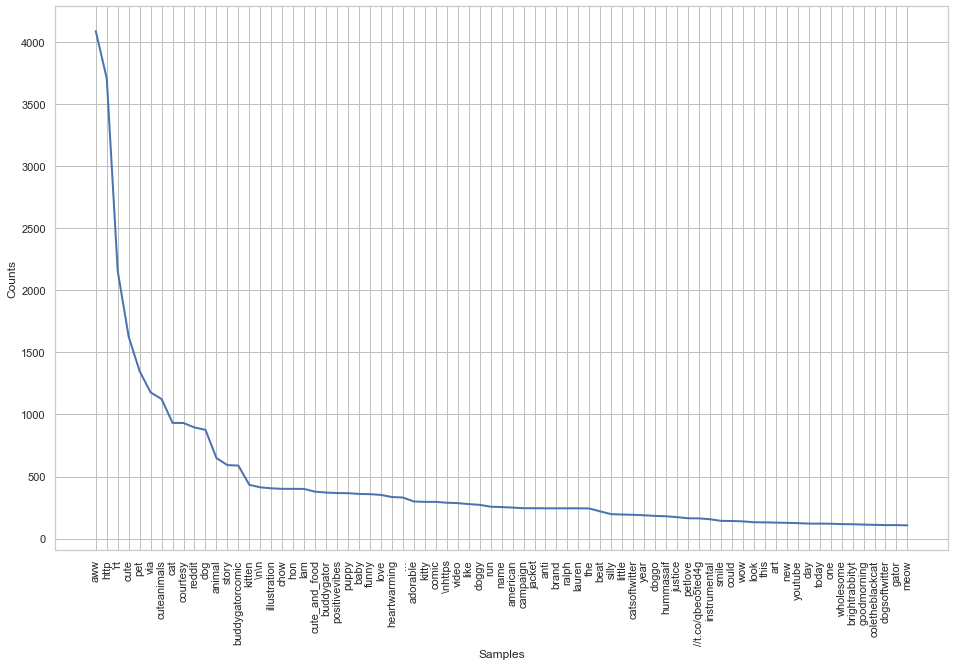

In [80]:
tokens = nltk.word_tokenize(str(data))
wnl = nltk.WordNetLemmatizer()
tokens2 = [t.lower() for t in tokens if len(t) > 2 and t not in en_stop_words] # Create a new list of words in the tweets by excluding the small words, which tend to be function words
lemma = [wnl.lemmatize(t) for t in tokens2]
words = lemma
words_lemma_freq = nltk.FreqDist(words)
plt.figure(figsize=(16,10))
words_lemma_freq.plot(75, cumulative=False)
plt.show()

In [81]:
from nltk.corpus import wordnet as wn

In [82]:
data_keywords = set(['dog', 'cat', 'turtle', 'fish', 'baby', 'bird', 'rabbit', 'horse', 'ferret', 'pig'])
data_labels = list(data_keywords)
keywords = {}

for term in data_keywords:
    for synset in wn.synsets(term):
        keywords[term] = synset.lemma_names()

keywords_keys = list(keywords.keys())
keyword_counts = {}

def wn_keyword_count(words):
    for key in keywords_keys:
        keyword_counts[key] = 0
    
    for word in words:
        for key in keywords_keys:
            for term in keywords[key]:
                if word.find(term) != -1:
                    keyword_counts[key] += 1

    return keyword_counts       

print(wn_keyword_count(words))

{'cat': 2067, 'baby': 595, 'pig': 16, 'bird': 106, 'rabbit': 156, 'horse': 10, 'turtle': 79, 'dog': 1874, 'ferret': 10, 'fish': 13}


In [83]:
results = pd.Series(wn_keyword_count(words), index=data_labels)
results

cat       2067
baby       595
pig         16
bird       106
rabbit     156
horse       10
turtle      79
dog       1874
ferret      10
fish        13
dtype: int64

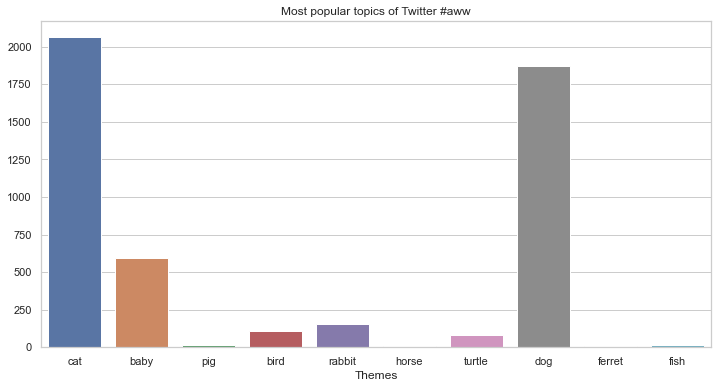

In [84]:
plt.figure(figsize=(12,6)) # These measurements are in inches.
plt.xlabel('Themes')
plt.title('Most popular topics of Twitter #aww')
sb.barplot(x=data_labels, y=results)
plt.show()

In [85]:
search_df['searchterm'] = '#aww'
search_df['language'] = 'English'

In [86]:
twitterdiscourse_df = pd.read_excel('data/aww.xlsx', na_values=['NA'])

In [69]:
# These are the search keywords
topic_keywords = set(['dog', 'cat', 'turtle', 'fish', 'baby', 'bird', 'rabbit', 'horse', 'ferret', 'pig'])
topic_labels = list(topic_keywords)

# Keyword coding manually identified terms
keywords2 = {}
keyword_counts2 = {}

def wn_keyword_count2(words):
    for term in topic_keywords:
        keyword_counts2[term] = 0
    
    for word in words:
        for term in topic_keywords:
            if word.find(term) != -1:
                keyword_counts2[term] += 1

    return keyword_counts2   

In [70]:
# This block does the content coding with the coding functions defined above.
content0_df = pd.DataFrame()

for tweet in twitterdiscourse_df.status:
    tweet_tokens = nltk.word_tokenize(tweet)
    tweet_tokens2 = [t.lower() for t in tweet_tokens] 
    content_coding0 = pd.Series(wn_keyword_count2(tweet_tokens2), index=list(topic_labels))
    content0_df = content0_df.append(content_coding0, ignore_index=True)
twittercoded_df = content0_df
twittercoded_df

# There are two relevant dataframes: twitterdiscourse_df contains the text data
# and twittercoded_df contains the coding results.

/var/folders/n3/7lr2xtgs72g16rs2rfk0gvgw0000gn/T/ipykernel_42745/1959654809.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  content0_df = content0_df.append(content_coding0, ignore_index=True)
/var/folders/n3/7lr2xtgs72g16rs2rfk0gvgw0000gn/T/ipykernel_42745/1959654809.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  content0_df = content0_df.append(content_coding0, ignore_index=True)
/var/folders/n3/7lr2xtgs72g16rs2rfk0gvgw0000gn/T/ipykernel_42745/1959654809.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  content0_df = content0_df.append(content_coding0, ignore_index=True)
/var/folders/n3/7lr2xtgs72g16rs2rfk0gvgw0000gn/T/ipykernel_42745/1959654809.py:8: FutureWarning: The frame.append method is deprecated and wil

,cat,baby,pig,bird,rabbit,horse,turtle,dog,ferret,fish
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,1,0,0,3,0,0
4996,0,0,0,0,1,0,0,3,0,0
4997,0,0,0,0,0,0,0,3,0,0
4998,0,0,0,0,0,0,0,4,0,0


In [72]:
twittercoded_df['baby'].describe()

count    5000.00000
mean        0.10940
std         0.51018
min         0.00000
25%         0.00000
50%         0.00000
75%         0.00000
max        10.00000
Name: baby, dtype: float64

In [73]:
X = twittercoded_df[['dog', 'cat', 'turtle', 'fish', 'bird', 'rabbit', 'horse', 'ferret', 'pig']]
Y = twittercoded_df['baby']
X = sm.add_constant(X)
model0 = sm.OLS(Y, X, missing='drop').fit()
print(model0.summary())

                            OLS Regression Results                            
Dep. Variable:                   baby   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     9.284
Date:                Sun, 18 Dec 2022   Prob (F-statistic):           4.23e-14
Time:                        20:46:52   Log-Likelihood:                -3687.7
No. Observations:                5000   AIC:                             7395.
Df Residuals:                    4990   BIC:                             7461.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0964      0.008     11.883      0.0

/Users/michaelsmith/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [74]:
keyword_cofreq = twittercoded_df.T.dot(twittercoded_df)
keyword_dist = 64000 - keyword_cofreq
keyword_dist  # distance matrix 

,cat,baby,pig,bird,rabbit,horse,turtle,dog,ferret,fish
cat,56101,63568,63996,63962,63879,63999,63999,63805,64000,63990
baby,63568,62639,63996,63999,63924,63999,64000,63863,63998,63995
pig,63996,63996,63968,64000,64000,64000,64000,64000,64000,64000
bird,63962,63999,64000,63861,63984,64000,64000,63999,64000,64000
rabbit,63879,63924,64000,63984,63728,64000,64000,63841,64000,64000
horse,63999,63999,64000,64000,64000,63984,64000,63996,64000,64000
turtle,63999,64000,64000,64000,64000,64000,63581,64000,64000,64000
dog,63805,63863,64000,63999,63841,63996,64000,58392,63997,64000
ferret,64000,63998,64000,64000,64000,64000,64000,63997,63984,64000
fish,63990,63995,64000,64000,64000,64000,64000,64000,64000,63985


In [75]:
mds = MDS(metric=False, n_components = 2, random_state=0, dissimilarity='precomputed')
pca = PCA(n_components=2)
twitterthemes_transform = mds.fit_transform(keyword_dist)
print(twitterthemes_transform)
print(mds.stress_)

[[-0.23870497 -0.0923186 ]
 [-0.09912458 -0.05226943]
 [ 0.35982762  0.34639233]
 [-0.10765458 -0.37552107]
 [-0.42277631  0.18366297]
 [ 0.10048949  0.49229752]
 [ 0.37970596 -0.53425122]
 [-0.51952125 -0.19735222]
 [ 0.69790604  0.09532306]
 [-0.13738729  0.05567736]]
1.1521885520962252


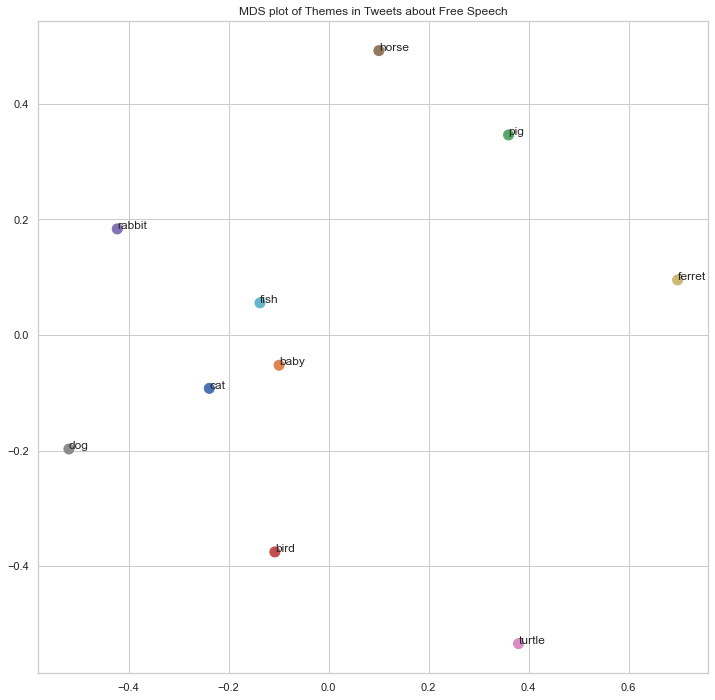

In [76]:
sb.set_theme(style="whitegrid")
fig = plt.figure(figsize=(12,12))
i = 0
while i < len(twittercoded_df.columns):
    plt.scatter(twitterthemes_transform[i,0], twitterthemes_transform[i,1], sizes=(100, 100))
    plt.text(twitterthemes_transform[i,0], twitterthemes_transform[i,1], twittercoded_df.columns[i])
    i += 1
plt.title('MDS plot of Tweets of #aww in English')
plt.show()